In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
path = r'C:\Users\user\Documents\GitHub\Notebooks-on-ml\TITANIC\Data\train.csv'
df = pd.read_csv(path)

train, test = df.drop(columns=['Survived']), df.Survived
    train['Surname'] = train['Name'].apply(lambda x: x.split(',')[0])
    train['Family_Survival'] = 0.5
    for grp, grp_df in train.groupby(['Surname', 'Fare']):
        if len(grp_df) > 1:
            for ind, row in grp_df.iterrows():
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                if smax == 1.0:
                    train.loc[ind, 'Family_Survival'] = 1
                elif smin == 0.0:
                    train.loc[ind, 'Family_Survival'] = 0
    for grp, grp_df in train.groupby('Ticket'):
        if len(grp_df) > 1:
            for ind, row in grp_df.iterrows():
                if (train.loc[ind, 'Family_Survival'] == 0.5):
                    smax = grp_df.drop(ind)['Survived'].max()
                    smin = grp_df.drop(ind)['Survived'].min()
                    if smax == 1.0:
                        train.loc[ind, 'Family_Survival'] = 1
                    elif smin == 0.0:
                        train.loc[ind, 'Family_Survival'] = 0
    df = df.merge(train[['PassengerId', 'Family_Survival']], on='PassengerId', how='left')
    
    df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    df['Title'] = df['Title'].replace(['Rev', 'Dr'], 'Service')
    df['Title'] = df['Title'].replace(['Jonkheer', 'Don', 'Sir', 'Lady', 'the Countess', 'Countess', 'Dona'], 'Noble')
    df['Title'] = df['Title'].replace(['Capt', 'Col', 'Major'], 'Officer')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

    df['Has_Cabin'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
    df['Deck'] = df['Cabin'].str[0].fillna('M')
    df['Deck'] = df['Deck'].replace(['A', 'B', 'C'], 'Top')
    df['Deck'] = df['Deck'].replace(['D', 'E'], 'Middle')
    df['Deck'] = df['Deck'].replace(['F', 'G', 'T', 'M'], 'Low')

    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['Ticket_Group_Size'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Age'] = df.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    cols_to_drop = ['Name', 'Ticket', 'Cabin', 'Surname'] if 'Surname' in df.columns else ['Name', 'Ticket', 'Cabin']
    df = df.drop(columns=cols_to_drop)
    df = pd.get_dummies(df, columns=['Title', 'Deck', 'Embarked'], drop_first=True)
    
    return df

print('left columns:', prepare_data(train).select_dtypes(include=['object']).columns.tolist())
print('left NaN values:', prepare_data(train).isna().sum().sum())
df_final = prepare_data(train).astype(float)

from sklearn.model_selection import train_test_split

X = df_final
y = test

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model_lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
model_lr.fit(X_train, y_train)
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)
accuracy_lr = model_lr.score(X_val, y_val)
accuracy = model.score(X_val, y_val)
print(f'Точность модели: {accuracy_lr:.2%}')
print(f'Точность модели: {accuracy:.2%}')

import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    min_samples_split = trial.suggest_int('min_samples_split', 5, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 4, 15)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    score = cross_val_score(model, X_train, y_train, cv=8, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Best trial:')
trial = study.best_trial
best_params = study.best_params
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

final_model = RandomForestClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)
accuracy_2 = final_model.score(X_val, y_val)
print(f'Точность модели: {accuracy_2:.2%}')

KeyError: 'Survived'

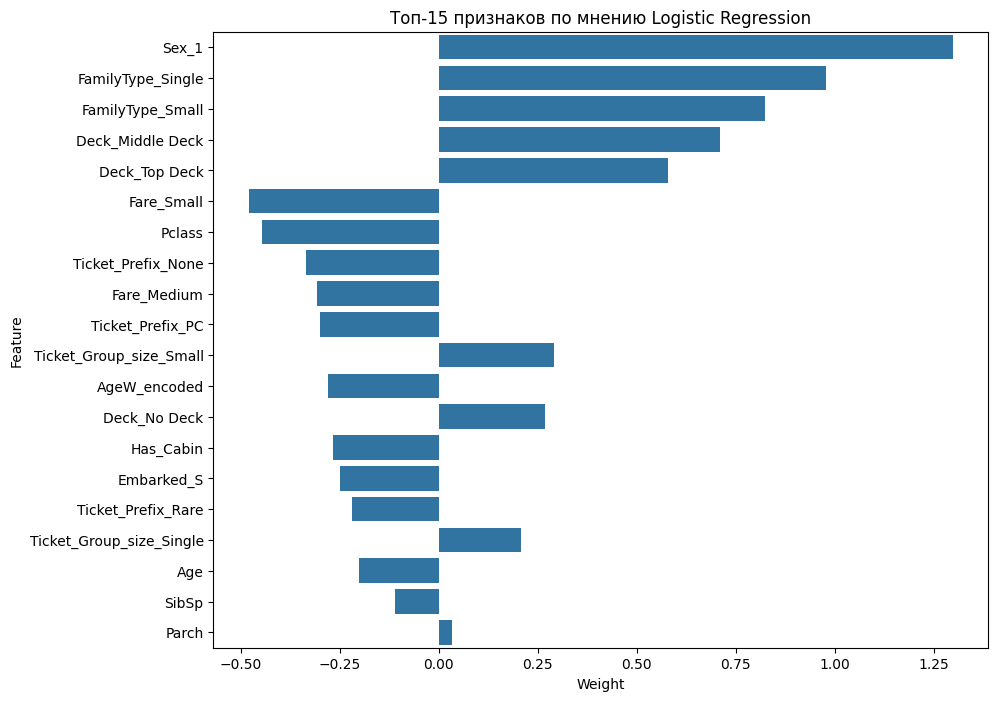

Embarked_Q                  0.004298
Ticket_Prefix_PC            0.004564
Ticket_Prefix_None          0.005607
Ticket_Prefix_Rare          0.006715
FamilyType_Single           0.010079
Fare_Medium                 0.011035
Deck_Top Deck               0.011065
Deck_Middle Deck            0.015851
Embarked_S                  0.017047
Parch                       0.017670
Ticket_Group_size_Single    0.019501
SibSp                       0.022945
Fare_Small                  0.034715
AgeW_encoded                0.036639
FamilyType_Small            0.043298
Ticket_Group_size_Small     0.043852
Deck_No Deck                0.052362
Has_Cabin                   0.054894
Age                         0.079160
Pclass                      0.091004
Sex_1                       0.417700
dtype: float64


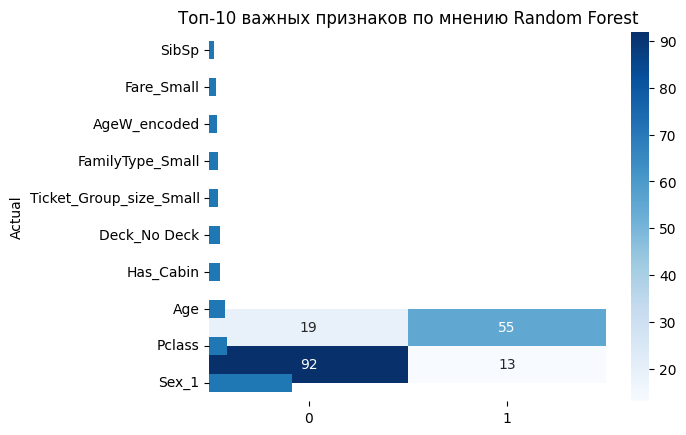

Средний возраст в ошибках: 33.703125
Распределение по классам в ошибках:
 Pclass
3.0    15
1.0    11
2.0     6
Name: count, dtype: int64


Text(50.722222222222214, 0.5, 'Actual')

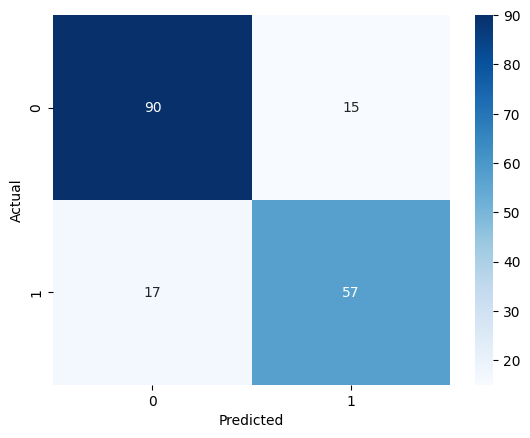

In [ ]:
import numpy as np
weights = model_lr.named_steps['logisticregression'].coef_[0]
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Weight': weights})
importance_df['AbsWeight'] = importance_df['Weight'].abs()
importance_df = importance_df.sort_values(by='AbsWeight', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(20), x='Weight', y='Feature')
plt.title('Топ-15 признаков по мнению Logistic Regression')
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_val, final_model.predict(X_val)), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

importances = pd.Series(final_model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=True).head(40))
importances.nlargest(10).plot(kind='barh')
plt.title('Топ-10 важных признаков по мнению Random Forest')
plt.show()

errors_df = X_val.copy()
errors_df['Actual'] = y_val
errors_df['Predicted'] = final_model.predict(X_val)
errors = errors_df[errors_df['Actual'] != errors_df['Predicted']]
errors.head(10)
print("Средний возраст в ошибках:", errors['Age'].mean())
print("Распределение по классам в ошибках:\n", errors['Pclass'].value_counts())

y_probs = final_model.predict_proba(X_val)[:, 1]
y_pred_custom = (y_probs >= 0.45).astype(int)
sns.heatmap(confusion_matrix(y_val, y_pred_custom), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(50.722222222222214, 0.5, 'Actual')

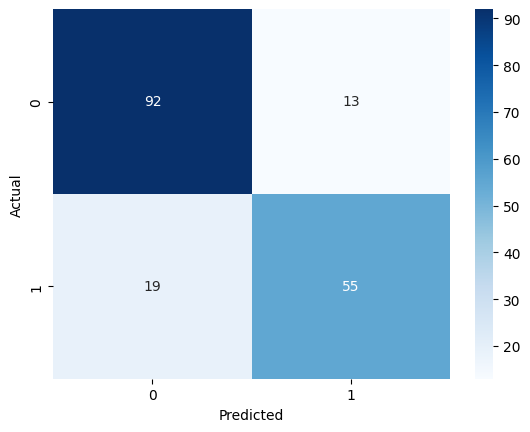

In [ ]:
y_probs = final_model.predict_proba(X_val)[:, 1]
y_pred_custom = (y_probs >= 0.5).astype(int)
sns.heatmap(confusion_matrix(y_val, y_pred_custom), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')